# Multidimensional Motif Discovery

## Finding a Motif in Multidimensional Time Series Data with MSTUMP

This example utilizes the main takeways from the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) research paper. For proper context, we highly recommend that you read the paper first but know that our implementations follow this paper closely.

To demonstrate the API and underlying principles, we will be looking at a simple toy dataset and will be seeing if we can identify a motif in multidimensional time series data. This is the same data that is presented throughout the original paper (above).

## Getting Started

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import urllib
import ssl
import io

The python functions below are going to be used throughout this example to automatically resize and create the plots that are displayed using the Matplotlib python plotting package.

In [2]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size

change_plot_size(20, 6, plt)

## Retrieve the Data

In [3]:
context = ssl.SSLContext()
url = "https://github.com/mcyeh/mstamp/blob/master/Python/toy_data.mat?raw=true"
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
mat = loadmat(data)
mdata = mat['data']
mdtype = mdata.dtype

df = pd.DataFrame(mdata, dtype=mdtype, columns=['T3', 'T2', 'T1'])
df.head()

,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


## Visualize the Raw Data

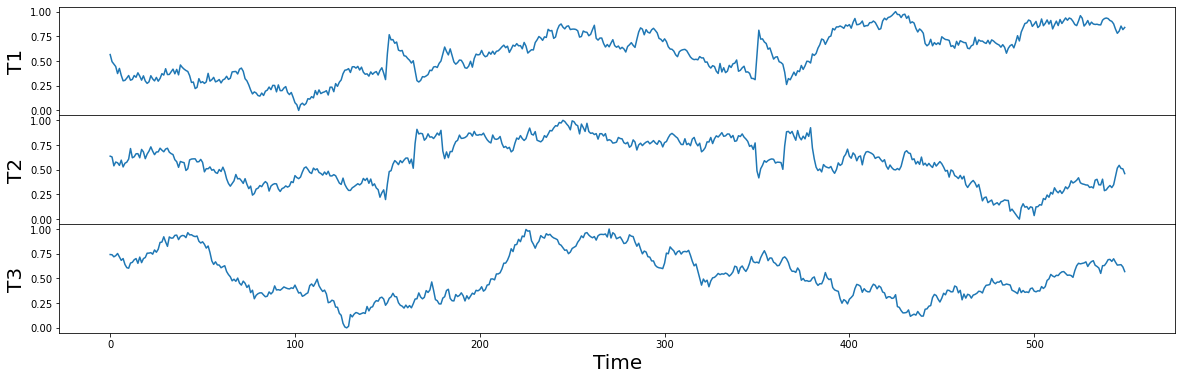

In [6]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
axs[0].set_ylabel('T1', fontsize='20')
axs[1].set_ylabel('T2', fontsize='20')
axs[2].set_ylabel('T3', fontsize='20')
axs[2].set_xlabel('Time', fontsize ='20')

axs[0].plot(df['T1'])
axs[1].plot(df['T2'])
axs[2].plot(df['T3'])

In this example data, we have a 3-dimensional time series labeled `T1`, `T2`, and `T3`. Can you spot where the motif is? That is, can you find the approximately repeating pattern that occurs around the same time? Does that motif exist in one, two, or all three dimensions?

If we run the class single dimensional motif discovery (with a window size of `m = 30`) independently on either of the first two dimensions (i.e., `T1` and `T2`):

In [ ]:
m = 30
mp_T1 = stumpy.stump(df['T1'], m)
mp_T2 = stumpy.stump(df['T2'], m)

we correctly, find the visually obvious motifs near locations `150` and `350`:

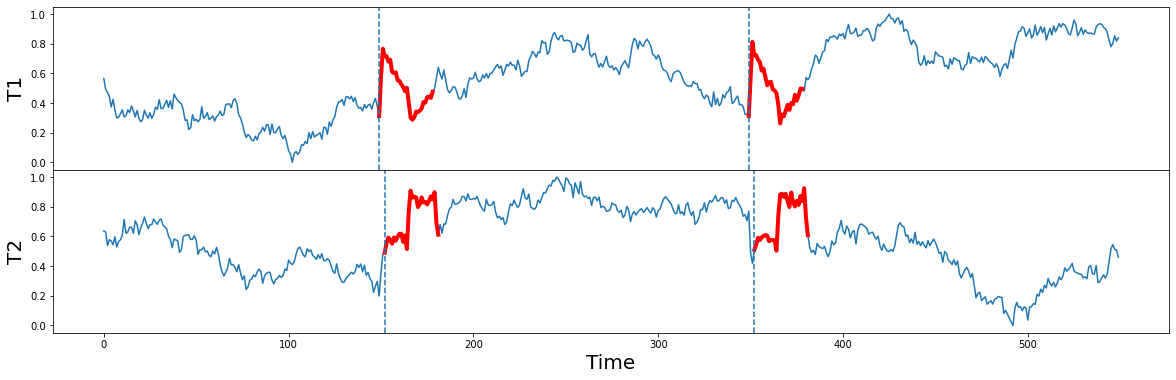

In [16]:
motif_idx_T1 = np.argpartition(mp_T1[:, 0], 2)[:2]
motif_idx_T2 = np.argpartition(mp_T2[:, 0], 2)[:2]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_ylabel('T1', fontsize='20')
axs[0].plot(df['T1'])
axs[1].set_ylabel('T2', fontsize='20')
axs[1].plot(df['T2'])
axs[1].set_xlabel('Time', fontsize ='20')

for idx in motif_idx_T1:
    axs[0].plot(df['T1'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[0].axvline(x=idx, linestyle="dashed")
    
for idx in motif_idx_T2:
    axs[1].plot(df['T2'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[1].axvline(x=idx, linestyle="dashed")

Notice that the locations of the motifs in each dimension (dotted vertical lines) are not perfectly aligned but this a great start. What if apply the same approach to the third dimension (i.e., `T3`):

In [17]:
mp_T3 = stumpy.stump(df['T3'], m)

can we successfully reach a consensus on where the motif is located?

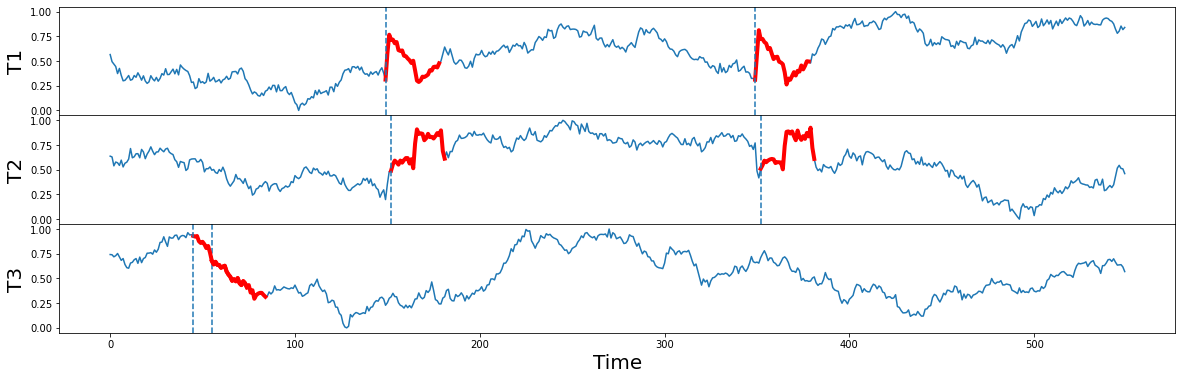

In [19]:
motif_idx_T3 = np.argpartition(mp_T3[:, 0], 2)[:2]

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_ylabel('T1', fontsize='20')
axs[0].plot(df['T1'])
axs[1].set_ylabel('T2', fontsize='20')
axs[1].plot(df['T2'])
axs[2].set_ylabel('T3', fontsize='20')
axs[2].plot(df['T3'])
axs[2].set_xlabel('Time', fontsize ='20')

for idx in motif_idx_T1:
    axs[0].plot(df['T1'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[0].axvline(x=idx, linestyle="dashed")
    
for idx in motif_idx_T2:
    axs[1].plot(df['T2'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[1].axvline(x=idx, linestyle="dashed")
    
for idx in motif_idx_T3:
    axs[2].plot(df['T3'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[2].axvline(x=idx, linestyle="dashed")    

Oh, no! The "motifs" in the third dimension (i.e., `T3`) barely resemble anything remotely useful and they are completely misaligned with the motifs found in `T1` and `T2`. 

As it turns out, `T3` was an irrelevant (decoy) dimension that was generated from a random walk and doesn't actually contain any motifs. This illustrates a few key points:

1. if there are additional irrelevant dimensions, you will do about as well as random chance at discovering multi-dimensional motifs if you don't ignore/dismiss those distracting dimensions
2. if you suspect that there motifs in only a subset of the time series, how do you know which dimensions are involved, or even know how many dimensions are involved?
3. doing motif search on all dimensions all dimensions is almost always guaranteed to produce meaningless results, even if a subset of dimensions has clear and unambiguous motifs (like our example above)

A quick survey of all current multi-dimensional motif discovery algorithms in the literature (see Section II in [Matrix Profile VI]((https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf))) reveals that they are slow, approximate, and brittle to irrelevant dimensions. In contrast, what we need is an algorithm that is fast, exact, and robust to hundreds of irrelevant dimensions. And this is where `stumpy.mstump` can help!

In [7]:
mp, indices = stumpy.mstump(df[['T1', 'T2', 'T3']], m)

Text(0.5, 0, 'Time')

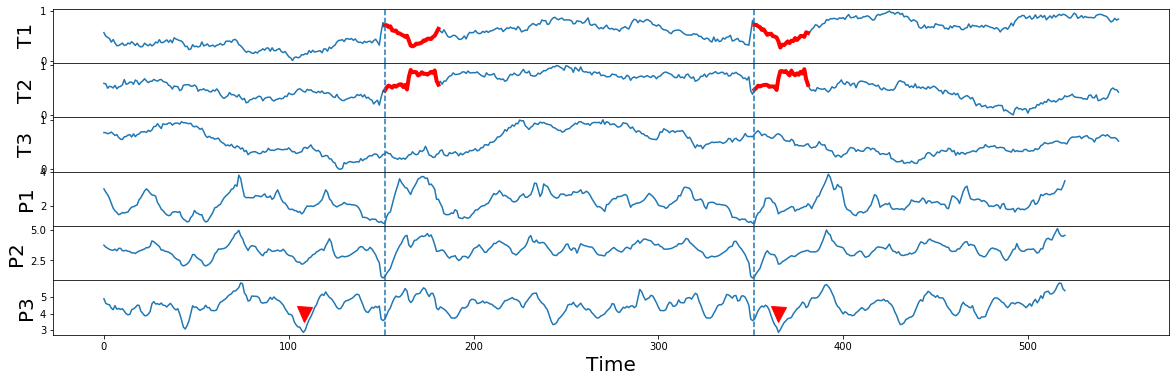

In [10]:
motif_idx = np.argpartition(mp[:, 0], 2)[:2]

fig, axs = plt.subplots(6, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_ylabel('T1', fontsize='20')
axs[1].set_ylabel('T2', fontsize='20')
axs[2].set_ylabel('T3', fontsize='20')

axs[0].plot(df['T1'])
axs[1].plot(df['T2'])
axs[2].plot(df['T3'])

for idx in motif_idx:
    axs[0].plot(df['T1'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[1].plot(df['T2'].iloc[idx:idx+m], c='red', linewidth=4)
    for p in range(6):
        axs[p].axvline(x=idx, linestyle="dashed")

axs[3].set_ylabel('P1', fontsize='20')
axs[4].set_ylabel('P2', fontsize='20')
axs[5].set_ylabel('P3', fontsize='20')

axs[3].plot(mp[:, 0])
axs[4].plot(mp[:, 1])
axs[5].plot(mp[:, 2])

motif_idx = np.argpartition(mp[:, 2], 2)[:2]
for idx in motif_idx:
    plt.plot(idx, 4, marker="v", markersize=15, color='red')

axs[5].set_xlabel('Time', fontsize ='20')

Matrix Profile Subspace

MDL

Guided Search

Include, Discords

## Scaling to Multiple Distributed Servers with MSTUMPED

## Summary

And that's it! You've just learned the basics of how to analyze multi-dimensional time series data using `stumpy.mstump` (or `stumpy.mstumped`)!

## Resources
​
[Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf)